# Load files

In [1]:
import pandas as pd
import numpy as np

In [2]:
import pickle

image_survey_metrics = pickle.load( open( "image_survey_metrics.pickle", "rb" ) )


* create connection uid-image_id

In [3]:
imgid_uid = image_survey_metrics[['user_id','image_id']].drop_duplicates() #set a matrix
get_uid_from_imgid = imgid_uid.set_index('image_id').to_dict()['user_id'] # img_id -> uid
get_imgids_from_uid = {k: list(v) for k,v in imgid_uid.groupby('user_id')["image_id"]} # uid -> img_id 

In [4]:
image_survey_metrics.drop_duplicates(inplace=True)

In [5]:
len(image_survey_metrics)

913668

In [6]:
image_survey_metrics.columns

Index([u'image_id', u'image_height', u'image_width', u'image_filter',
       u'image_posted_time', u'data_memorability', u'user_id',
       u'user_followed_by', u'user_follows', u'user_posted_photos',
       u'anp_label', u'anp_sentiment', u'emotion_score', u'emotion_label',
       u'data_amz_label', u'data_amz_label_confidence', u'face_id',
       u'face_gender', u'face_gender_confidence', u'face_age_range_high',
       u'face_age_range_low', u'face_sunglasses', u'face_beard',
       u'face_beard_confidence', u'face_mustache', u'face_mustache_confidence',
       u'face_smile', u'face_smile_confidence', u'eyeglasses',
       u'eyeglasses_confidence', u'face_emo', u'emo_confidence', u'id',
       u'gender', u'born', u'education', u'employed', u'income', u'A_2',
       u'N_1', u'P_1', u'E_1', u'A_1', u'H_1', u'M_1', u'R_1', u'M_2', u'E_2',
       u'LON', u'H_2', u'P_2', u'N_2', u'A_3', u'N_3', u'E_3', u'H_3', u'R_2',
       u'M_3', u'R_3', u'P_3', u'HAP', u'insta_user_id', u'end_q', u'P'

In [7]:
#Convenient way to select multiple columns to get
for c in image_survey_metrics.columns:
    print "'"+c+"',"

'image_id',
'image_height',
'image_width',
'image_filter',
'image_posted_time',
'data_memorability',
'user_id',
'user_followed_by',
'user_follows',
'user_posted_photos',
'anp_label',
'anp_sentiment',
'emotion_score',
'emotion_label',
'data_amz_label',
'data_amz_label_confidence',
'face_id',
'face_gender',
'face_gender_confidence',
'face_age_range_high',
'face_age_range_low',
'face_sunglasses',
'face_beard',
'face_beard_confidence',
'face_mustache',
'face_mustache_confidence',
'face_smile',
'face_smile_confidence',
'eyeglasses',
'eyeglasses_confidence',
'face_emo',
'emo_confidence',
'id',
'gender',
'born',
'education',
'employed',
'income',
'A_2',
'N_1',
'P_1',
'E_1',
'A_1',
'H_1',
'M_1',
'R_1',
'M_2',
'E_2',
'LON',
'H_2',
'P_2',
'N_2',
'A_3',
'N_3',
'E_3',
'H_3',
'R_2',
'M_3',
'R_3',
'P_3',
'HAP',
'insta_user_id',
'end_q',
'P',
'E',
'R',
'M',
'A',
'PERMA',
'N_EMO',
'P_EMO',
'imagecount',
'comment_count',
'like_count',


# Construct the final ANP matrix (for each image), with the corresponding features extracted

* Load ANP dataset

In [8]:
# # LOAD FROM feather !!!!!!!!
# import feather
# anp_df = feather.api.read_dataframe('data_science_case/anp.feather')

In [9]:
#load ANPs from Aris pickle df
anp_df = image_survey_metrics[['image_id', 'anp_label', 'anp_sentiment', 'emotion_score',
       'emotion_label']].drop_duplicates().set_index("image_id")
del anp_df.index.name

In [10]:
anp_df.head(15)

,anp_label,anp_sentiment,emotion_score,emotion_label
1222392034123570094_53918317,comic_life,0.129,0.1169,amazement
1222392034123570094_53918317,funny_quotes,0.078,0.1554,amazement
1222392034123570094_53918317,unique_gifts,0.049,0.1316,interest
1222392034123570094_53918317,true_story,0.371,0.1067,interest
1222392034123570094_53918317,long_lashes,-0.021,0.1479,ecstasy
1226052661266340072_53918317,comic_life,0.129,0.1169,amazement
1226052661266340072_53918317,silly_faces,-0.230,0.1281,sadness
1226052661266340072_53918317,stupid_face,-0.750,0.1028,sadness
1226052661266340072_53918317,hot_lips,0.017,0.2222,amazement
1226052661266340072_53918317,little_chef,-0.056,0.0991,joy


In [11]:
len(anp_df)

26901

### Create features based on ANPs for each image

In [12]:
#generate a new df containing the classes corresponding to Butchniks emotions
classes = anp_df.emotion_label.unique()
from sklearn.preprocessing import label_binarize
anp_final = pd.DataFrame(label_binarize(anp_df.emotion_label, classes=classes),columns=classes,index=anp_df.index)

anp_final.head()

#put the value of emotion score in the corresponding row of the image
anp_final = anp_final.multiply(anp_df.emotion_score,axis=0)
anp_final.head(20)

,amazement,interest,ecstasy,sadness,joy,surprise,anger,fear,terror,trust,annoyance,serenity,rage,boredom,grief,pensiveness,acceptance,disgust,distraction,anticipation
1222392034123570094_53918317,0.1169,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1222392034123570094_53918317,0.1554,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1222392034123570094_53918317,0.0000,0.1316,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1222392034123570094_53918317,0.0000,0.1067,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1222392034123570094_53918317,0.0000,0.0000,0.1479,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1226052661266340072_53918317,0.1169,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1226052661266340072_53918317,0.0000,0.0000,0.0000,0.1281,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1226052661266340072_53918317,0.0000,0.0000,0.0000,0.1028,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1226052661266340072_53918317,0.2222,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1226052661266340072_53918317,0.0000,0.0000,0.0000,0.0000,0.0991,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#sum all emotions over each image
anp_final = anp_final.groupby(anp_final.index).sum()
anp_final.head(10)

,amazement,interest,ecstasy,sadness,joy,surprise,anger,fear,terror,trust,annoyance,serenity,rage,boredom,grief,pensiveness,acceptance,disgust,distraction,anticipation
1133540080528825625_235671446,0.3481,0.0000,0.0,0.2466,0.0000,0.0000,0.0,0.000,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.1224,0.0,0.0,0.0,0.0
1133574285848421662_288335200,0.7115,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.098,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
1133585745084332210_50853245,0.0000,0.0000,0.0,0.2300,0.6469,0.0000,0.0,0.000,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
1133669091363706914_31736205,0.5401,0.1344,0.0,0.0000,0.1377,0.0000,0.0,0.000,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
1133670195944446080_183823541,0.1135,0.1295,0.0,0.1124,0.0000,0.0823,0.0,0.000,0.0000,0.0,0.0,0.0608,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
1133670438148724870_183823541,0.3665,0.0000,0.0,0.0000,0.1270,0.0823,0.0,0.000,0.1317,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
1133677357037016056_249861555,0.9123,0.2203,0.0,0.0000,0.0000,0.0000,0.0,0.000,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
1133762711687139568_703978203,0.2201,0.0000,0.0,0.2703,0.0000,0.0000,0.0,0.000,0.1495,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
1133789380531429768_265063047,0.3301,0.0000,0.0,0.1024,0.0839,0.0000,0.0,0.000,0.0000,0.0,0.0,0.1765,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
1133857277262041337_703978203,0.4396,0.0000,0.0,0.1223,0.1152,0.0000,0.0,0.000,0.0000,0.0,0.0,0.1213,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0


In [14]:
#sum all sentiments of label corresponding to the image
anp_final['anp_sentiment'] = anp_df['anp_sentiment'].groupby(anp_df.index).sum()
anp_final.head(10)

,amazement,interest,ecstasy,sadness,joy,surprise,anger,fear,terror,trust,...,serenity,rage,boredom,grief,pensiveness,acceptance,disgust,distraction,anticipation,anp_sentiment
1133540080528825625_235671446,0.3481,0.0000,0.0,0.2466,0.0000,0.0000,0.0,0.000,0.0000,0.0,...,0.0000,0.0,0.0,0.0,0.1224,0.0,0.0,0.0,0.0,-0.534
1133574285848421662_288335200,0.7115,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.098,0.0000,0.0,...,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.976
1133585745084332210_50853245,0.0000,0.0000,0.0,0.2300,0.6469,0.0000,0.0,0.000,0.0000,0.0,...,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.417
1133669091363706914_31736205,0.5401,0.1344,0.0,0.0000,0.1377,0.0000,0.0,0.000,0.0000,0.0,...,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.763
1133670195944446080_183823541,0.1135,0.1295,0.0,0.1124,0.0000,0.0823,0.0,0.000,0.0000,0.0,...,0.0608,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.042
1133670438148724870_183823541,0.3665,0.0000,0.0,0.0000,0.1270,0.0823,0.0,0.000,0.1317,0.0,...,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.948
1133677357037016056_249861555,0.9123,0.2203,0.0,0.0000,0.0000,0.0000,0.0,0.000,0.0000,0.0,...,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.972
1133762711687139568_703978203,0.2201,0.0000,0.0,0.2703,0.0000,0.0000,0.0,0.000,0.1495,0.0,...,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.597
1133789380531429768_265063047,0.3301,0.0000,0.0,0.1024,0.0839,0.0000,0.0,0.000,0.0000,0.0,...,0.1765,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.421
1133857277262041337_703978203,0.4396,0.0000,0.0,0.1223,0.1152,0.0000,0.0,0.000,0.0000,0.0,...,0.1213,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,-0.493


In [15]:
# TODO normalize matrix ????

# Export matrix

In [16]:
# extract the matrix
import pickle
with open ('ANP_features.pickle','wb') as f:
    pickle.dump(anp_final,f)

# Correlate

### Load Y variable(s)

In [17]:
image_survey_metrics.columns

Index([u'image_id', u'image_height', u'image_width', u'image_filter',
       u'image_posted_time', u'data_memorability', u'user_id',
       u'user_followed_by', u'user_follows', u'user_posted_photos',
       u'anp_label', u'anp_sentiment', u'emotion_score', u'emotion_label',
       u'data_amz_label', u'data_amz_label_confidence', u'face_id',
       u'face_gender', u'face_gender_confidence', u'face_age_range_high',
       u'face_age_range_low', u'face_sunglasses', u'face_beard',
       u'face_beard_confidence', u'face_mustache', u'face_mustache_confidence',
       u'face_smile', u'face_smile_confidence', u'eyeglasses',
       u'eyeglasses_confidence', u'face_emo', u'emo_confidence', u'id',
       u'gender', u'born', u'education', u'employed', u'income', u'A_2',
       u'N_1', u'P_1', u'E_1', u'A_1', u'H_1', u'M_1', u'R_1', u'M_2', u'E_2',
       u'LON', u'H_2', u'P_2', u'N_2', u'A_3', u'N_3', u'E_3', u'H_3', u'R_2',
       u'M_3', u'R_3', u'P_3', u'HAP', u'insta_user_id', u'end_q', u'P'

In [18]:
PERMA_df = image_survey_metrics[['image_id','user_id','P',
    'E',
    'R',
    'M',
    'A',
    'PERMA',
    'image_posted_time',
    'end_q']].drop_duplicates()#.set_index('image_id')
del PERMA_df.index.name
print 'len(PERMA_df):', len(PERMA_df)
print ' '
PERMA_df.head(15)

len(PERMA_df): 5650
 


,image_id,user_id,P,E,R,M,A,PERMA,image_posted_time,end_q
0,1222392034123570094_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-04-06 11:01:47,2016-12-05 14:06:38
180,1226052661266340072_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-04-11 12:14:48,2016-12-05 14:06:38
405,1221675301549103374_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-04-05 11:17:46,2016-12-05 14:06:38
615,1219523282340141399_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-04-02 12:02:05,2016-12-05 14:06:38
840,1219058668716415516_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-04-01 20:38:59,2016-12-05 14:06:38
1080,1372870097060159201_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-10-31 01:54:50,2016-12-05 14:06:38
1125,1376341630843643565_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-11-04 20:52:09,2016-12-05 14:06:38
1245,1373407612938533591_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-10-31 19:42:47,2016-12-05 14:06:38
1335,1372871586851626025_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-10-31 01:57:48,2016-12-05 14:06:38
1410,1376342482815974929_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-11-04 20:53:51,2016-12-05 14:06:38


In [19]:
anp_final.head(15)

,amazement,interest,ecstasy,sadness,joy,surprise,anger,fear,terror,trust,...,serenity,rage,boredom,grief,pensiveness,acceptance,disgust,distraction,anticipation,anp_sentiment
1133540080528825625_235671446,0.3481,0.0000,0.0,0.2466,0.0000,0.0000,0.0000,0.000,0.0000,0.0,...,0.0000,0.0,0.0,0.0,0.1224,0.0,0.0,0.0,0.0,-0.534
1133574285848421662_288335200,0.7115,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.098,0.0000,0.0,...,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.976
1133585745084332210_50853245,0.0000,0.0000,0.0,0.2300,0.6469,0.0000,0.0000,0.000,0.0000,0.0,...,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.417
1133669091363706914_31736205,0.5401,0.1344,0.0,0.0000,0.1377,0.0000,0.0000,0.000,0.0000,0.0,...,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.763
1133670195944446080_183823541,0.1135,0.1295,0.0,0.1124,0.0000,0.0823,0.0000,0.000,0.0000,0.0,...,0.0608,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.042
1133670438148724870_183823541,0.3665,0.0000,0.0,0.0000,0.1270,0.0823,0.0000,0.000,0.1317,0.0,...,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.948
1133677357037016056_249861555,0.9123,0.2203,0.0,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0,...,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.972
1133762711687139568_703978203,0.2201,0.0000,0.0,0.2703,0.0000,0.0000,0.0000,0.000,0.1495,0.0,...,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.597
1133789380531429768_265063047,0.3301,0.0000,0.0,0.1024,0.0839,0.0000,0.0000,0.000,0.0000,0.0,...,0.1765,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.421
1133857277262041337_703978203,0.4396,0.0000,0.0,0.1223,0.1152,0.0000,0.0000,0.000,0.0000,0.0,...,0.1213,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,-0.493


# Aggregate score for each user

* Calculate weight for each image based on | survey date - image posted date |

In [21]:
from WeightsByDate import Get_Linear_Weight

In [22]:
PERMA_df.head(10)

,image_id,user_id,P,E,R,M,A,PERMA,image_posted_time,end_q
0,1222392034123570094_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-04-06 11:01:47,2016-12-05 14:06:38
180,1226052661266340072_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-04-11 12:14:48,2016-12-05 14:06:38
405,1221675301549103374_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-04-05 11:17:46,2016-12-05 14:06:38
615,1219523282340141399_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-04-02 12:02:05,2016-12-05 14:06:38
840,1219058668716415516_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-04-01 20:38:59,2016-12-05 14:06:38
1080,1372870097060159201_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-10-31 01:54:50,2016-12-05 14:06:38
1125,1376341630843643565_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-11-04 20:52:09,2016-12-05 14:06:38
1245,1373407612938533591_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-10-31 19:42:47,2016-12-05 14:06:38
1335,1372871586851626025_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-10-31 01:57:48,2016-12-05 14:06:38
1410,1376342482815974929_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-11-04 20:53:51,2016-12-05 14:06:38


In [23]:
#calculate the image weight
PERMA_df['image_weight'] = map(lambda img_date, survey_date: Get_Linear_Weight(given_date=img_date, peak_date=survey_date) ,
    PERMA_df.image_posted_time, PERMA_df.end_q)

In [24]:
PERMA_df[210:230]

,image_id,user_id,P,E,R,M,A,PERMA,image_posted_time,end_q,image_weight
110082,1144232452408721286_143854846,143854846.0,8,6.0,6.0,7.0,6.0,8,2015-12-20 14:52:39,2016-12-05 14:44:35,0.000000
110172,1169036622571487103_143854846,143854846.0,8,6.0,6.0,7.0,6.0,8,2016-01-23 20:14:06,2016-12-05 14:44:35,0.000000
110472,1158061664538181389_143854846,143854846.0,8,6.0,6.0,7.0,6.0,8,2016-01-08 16:48:50,2016-12-05 14:44:35,0.000000
110517,1156642907580252118_143854846,143854846.0,8,6.0,6.0,7.0,6.0,8,2016-01-06 17:50:00,2016-12-05 14:44:35,0.000000
110667,1158905688115362825_143854846,143854846.0,8,6.0,6.0,7.0,6.0,8,2016-01-09 20:45:45,2016-12-05 14:44:35,0.000000
110682,1150744237311770545_143854846,143854846.0,8,6.0,6.0,7.0,6.0,8,2015-12-29 14:30:24,2016-12-05 14:44:35,0.000000
110952,1181298795792285377_143854846,143854846.0,8,6.0,6.0,7.0,6.0,8,2016-02-09 18:16:51,2016-12-05 14:44:35,0.000000
111102,1197133007875194133_143854846,143854846.0,8,6.0,6.0,7.0,6.0,8,2016-03-02 14:36:37,2016-12-05 14:44:35,0.000000
111162,1185559898118405178_143854846,143854846.0,8,6.0,6.0,7.0,6.0,8,2016-02-15 15:22:54,2016-12-05 14:44:35,0.000000
111312,1203017327248653606_143854846,143854846.0,8,6.0,6.0,7.0,6.0,8,2016-03-10 17:27:42,2016-12-05 14:44:35,0.000000


In [25]:
'''
Usage: get_img_weight['1300904299735789673_143854846']
> 0.0
'''

get_img_weight = PERMA_df.set_index('image_id').to_dict()['image_weight']


"\nUsage: get_img_weight['1300904299735789673_143854846']\n> 0.0\n"

In [27]:
get_img_weight['1300904299735789673_143854846']

0.0

* Multiply weights of image (based on index) * whole dataframe

In [38]:
#get index based weight
anp_final_weighted = anp_final.multiply(map(lambda x: get_img_weight[x],anp_final.index),axis=0)

In [39]:
anp_final_weighted.head(10)

,amazement,interest,ecstasy,sadness,joy,surprise,anger,fear,terror,trust,...,serenity,rage,boredom,grief,pensiveness,acceptance,disgust,distraction,anticipation,anp_sentiment
1133540080528825625_235671446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
1133574285848421662_288335200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1133585745084332210_50853245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1133669091363706914_31736205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1133670195944446080_183823541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1133670438148724870_183823541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1133677357037016056_249861555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1133762711687139568_703978203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1133789380531429768_265063047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1133857277262041337_703978203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0


* Calculate avg Putchniks score per user



In [51]:
anp_final_weighted['user_id'] = map(lambda x: get_uid_from_imgid[x], anp_final_weighted.index)

In [55]:
anp_final_weighted_per_user = anp_final_weighted.groupby('user_id').mean()

In [56]:
anp_final_weighted_per_user.head(10)

,amazement,interest,ecstasy,sadness,joy,surprise,anger,fear,terror,trust,...,serenity,rage,boredom,grief,pensiveness,acceptance,disgust,distraction,anticipation,anp_sentiment
user_id,,,,,,,,,,,,,,,,,,,,,
1619510.0,0.071850,0.009965,0.0,0.013910,0.023672,0.001961,0.002599,0.002771,0.002216,0.000000,...,0.000000,0.000000,0.000000,0.001122,0.000000,0.000000,0.000000,0.0,0.000000,0.029119
2829661.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3069744.0,0.010353,0.012421,0.0,0.000000,0.020379,0.000000,0.005724,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.017067
3988856.0,0.087804,0.015169,0.0,0.020925,0.039526,0.000000,0.008813,0.000000,0.000000,0.000978,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.200164
4185084.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
6734387.0,0.108243,0.000000,0.0,0.004470,0.041049,0.000000,0.001506,0.000000,0.002494,0.004376,...,0.009897,0.000000,0.000000,0.000000,0.000000,0.004764,0.000000,0.0,0.000000,0.169244
7410944.0,0.039452,0.007721,0.0,0.021227,0.029809,0.000000,0.003205,0.000000,0.002124,0.000819,...,0.005138,0.000000,0.001762,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.139702
8854187.0,0.082226,0.006923,0.0,0.053900,0.121371,0.000000,0.029184,0.005344,0.000931,0.001475,...,0.001463,0.003421,0.000670,0.000000,0.000938,0.000000,0.000000,0.0,0.001373,0.520969
11520833.0,0.091468,0.014600,0.0,0.025714,0.033500,0.000000,0.000000,0.005250,0.000000,0.000000,...,0.002200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.061285


In [58]:
len(anp_final_weighted_per_user)

125

In [62]:
PERMA_df.head(10)

,image_id,user_id,P,E,R,M,A,PERMA,image_posted_time,end_q,image_weight
0,1222392034123570094_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-04-06 11:01:47,2016-12-05 14:06:38,0.000000
180,1226052661266340072_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-04-11 12:14:48,2016-12-05 14:06:38,0.000000
405,1221675301549103374_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-04-05 11:17:46,2016-12-05 14:06:38,0.000000
615,1219523282340141399_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-04-02 12:02:05,2016-12-05 14:06:38,0.000000
840,1219058668716415516_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-04-01 20:38:59,2016-12-05 14:06:38,0.000000
1080,1372870097060159201_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-10-31 01:54:50,2016-12-05 14:06:38,0.611111
1125,1376341630843643565_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-11-04 20:52:09,2016-12-05 14:06:38,0.666667
1245,1373407612938533591_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-10-31 19:42:47,2016-12-05 14:06:38,0.622222
1335,1372871586851626025_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-10-31 01:57:48,2016-12-05 14:06:38,0.611111
1410,1376342482815974929_53918317,53918317.0,1,7.0,8.0,5.0,5.0,1,2016-11-04 20:53:51,2016-12-05 14:06:38,0.666667


In [64]:
PERMA_df = PERMA_df[['user_id','image_posted_time','image_weight','P','E','R','M','A','PERMA']].set_index('user_id')

In [67]:
PERMA_df.head(10)

,image_posted_time,image_weight,P,E,R,M,A,PERMA
user_id,,,,,,,,
53918317.0,2016-04-06 11:01:47,0.000000,1,7.0,8.0,5.0,5.0,1
53918317.0,2016-04-11 12:14:48,0.000000,1,7.0,8.0,5.0,5.0,1
53918317.0,2016-04-05 11:17:46,0.000000,1,7.0,8.0,5.0,5.0,1
53918317.0,2016-04-02 12:02:05,0.000000,1,7.0,8.0,5.0,5.0,1
53918317.0,2016-04-01 20:38:59,0.000000,1,7.0,8.0,5.0,5.0,1
53918317.0,2016-10-31 01:54:50,0.611111,1,7.0,8.0,5.0,5.0,1
53918317.0,2016-11-04 20:52:09,0.666667,1,7.0,8.0,5.0,5.0,1
53918317.0,2016-10-31 19:42:47,0.622222,1,7.0,8.0,5.0,5.0,1
53918317.0,2016-10-31 01:57:48,0.611111,1,7.0,8.0,5.0,5.0,1


In [69]:
anp_final_weighted_per_user.head(10)

,amazement,interest,ecstasy,sadness,joy,surprise,anger,fear,terror,trust,...,serenity,rage,boredom,grief,pensiveness,acceptance,disgust,distraction,anticipation,anp_sentiment
user_id,,,,,,,,,,,,,,,,,,,,,
1619510.0,0.071850,0.009965,0.0,0.013910,0.023672,0.001961,0.002599,0.002771,0.002216,0.000000,...,0.000000,0.000000,0.000000,0.001122,0.000000,0.000000,0.000000,0.0,0.000000,0.029119
2829661.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3069744.0,0.010353,0.012421,0.0,0.000000,0.020379,0.000000,0.005724,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.017067
3988856.0,0.087804,0.015169,0.0,0.020925,0.039526,0.000000,0.008813,0.000000,0.000000,0.000978,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.200164
4185084.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
6734387.0,0.108243,0.000000,0.0,0.004470,0.041049,0.000000,0.001506,0.000000,0.002494,0.004376,...,0.009897,0.000000,0.000000,0.000000,0.000000,0.004764,0.000000,0.0,0.000000,0.169244
7410944.0,0.039452,0.007721,0.0,0.021227,0.029809,0.000000,0.003205,0.000000,0.002124,0.000819,...,0.005138,0.000000,0.001762,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.139702
8854187.0,0.082226,0.006923,0.0,0.053900,0.121371,0.000000,0.029184,0.005344,0.000931,0.001475,...,0.001463,0.003421,0.000670,0.000000,0.000938,0.000000,0.000000,0.0,0.001373,0.520969
11520833.0,0.091468,0.014600,0.0,0.025714,0.033500,0.000000,0.000000,0.005250,0.000000,0.000000,...,0.002200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.061285


In [71]:
anp_final_weighted_per_user.merge(PERMA_df,right_index=True,left_index=True)

,amazement,interest,ecstasy,sadness,joy,surprise,anger,fear,terror,trust,...,anticipation,anp_sentiment,image_posted_time,image_weight,P,E,R,M,A,PERMA
user_id,,,,,,,,,,,,,,,,,,,,,
1.619510e+06,0.071850,0.009965,0.0,0.013910,0.023672,0.001961,0.002599,0.002771,0.002216,0.000000,...,0.0,0.029119,2016-01-01 07:31:12,0.000000,4,7.0,4.0,5.0,4.0,4
1.619510e+06,0.071850,0.009965,0.0,0.013910,0.023672,0.001961,0.002599,0.002771,0.002216,0.000000,...,0.0,0.029119,2015-12-25 03:39:58,0.000000,4,7.0,4.0,5.0,4.0,4
1.619510e+06,0.071850,0.009965,0.0,0.013910,0.023672,0.001961,0.002599,0.002771,0.002216,0.000000,...,0.0,0.029119,2015-12-25 01:43:30,0.000000,4,7.0,4.0,5.0,4.0,4
1.619510e+06,0.071850,0.009965,0.0,0.013910,0.023672,0.001961,0.002599,0.002771,0.002216,0.000000,...,0.0,0.029119,2016-02-04 22:59:26,0.000000,4,7.0,4.0,5.0,4.0,4
1.619510e+06,0.071850,0.009965,0.0,0.013910,0.023672,0.001961,0.002599,0.002771,0.002216,0.000000,...,0.0,0.029119,2016-02-14 14:32:30,0.000000,4,7.0,4.0,5.0,4.0,4
1.619510e+06,0.071850,0.009965,0.0,0.013910,0.023672,0.001961,0.002599,0.002771,0.002216,0.000000,...,0.0,0.029119,2016-02-15 02:04:48,0.000000,4,7.0,4.0,5.0,4.0,4
1.619510e+06,0.071850,0.009965,0.0,0.013910,0.023672,0.001961,0.002599,0.002771,0.002216,0.000000,...,0.0,0.029119,2016-03-10 20:02:31,0.000000,4,7.0,4.0,5.0,4.0,4
1.619510e+06,0.071850,0.009965,0.0,0.013910,0.023672,0.001961,0.002599,0.002771,0.002216,0.000000,...,0.0,0.029119,2016-01-21 07:00:44,0.000000,4,7.0,4.0,5.0,4.0,4
1.619510e+06,0.071850,0.009965,0.0,0.013910,0.023672,0.001961,0.002599,0.002771,0.002216,0.000000,...,0.0,0.029119,2016-02-15 09:05:35,0.000000,4,7.0,4.0,5.0,4.0,4


# Correlations

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
import seaborn as sns

In [98]:
for c in image_survey_metrics.columns:
    print '"%s",' %c

"image_id",
"image_height",
"image_width",
"image_filter",
"image_posted_time",
"data_memorability",
"user_id",
"user_followed_by",
"user_follows",
"user_posted_photos",
"anp_label",
"anp_sentiment",
"emotion_score",
"emotion_label",
"data_amz_label",
"data_amz_label_confidence",
"face_id",
"face_gender",
"face_gender_confidence",
"face_age_range_high",
"face_age_range_low",
"face_sunglasses",
"face_beard",
"face_beard_confidence",
"face_mustache",
"face_mustache_confidence",
"face_smile",
"face_smile_confidence",
"eyeglasses",
"eyeglasses_confidence",
"face_emo",
"emo_confidence",
"id",
"gender",
"born",
"education",
"employed",
"income",
"A_2",
"N_1",
"P_1",
"E_1",
"A_1",
"H_1",
"M_1",
"R_1",
"M_2",
"E_2",
"LON",
"H_2",
"P_2",
"N_2",
"A_3",
"N_3",
"E_3",
"H_3",
"R_2",
"M_3",
"R_3",
"P_3",
"HAP",
"insta_user_id",
"end_q",
"P",
"E",
"R",
"M",
"A",
"PERMA",
"N_EMO",
"P_EMO",
"imagecount",
"comment_count",
"like_count",


In [96]:
image_survey_metrics.head(10)

,image_id,image_height,image_width,image_filter,image_posted_time,data_memorability,user_id,user_followed_by,user_follows,user_posted_photos,...,E,R,M,A,PERMA,N_EMO,P_EMO,imagecount,comment_count,like_count
0,1222392034123570094_53918317,640.0,640.0,Normal,2016-04-06 11:01:47,0.844465,53918317.0,100.0,174.0,105.0,...,7.0,8.0,5.0,5.0,1,8.0,1,105.0,0.0,2.0
1,1222392034123570094_53918317,640.0,640.0,Normal,2016-04-06 11:01:47,0.844465,53918317.0,100.0,174.0,105.0,...,7.0,8.0,5.0,5.0,1,8.0,1,105.0,0.0,2.0
2,1222392034123570094_53918317,640.0,640.0,Normal,2016-04-06 11:01:47,0.844465,53918317.0,100.0,174.0,105.0,...,7.0,8.0,5.0,5.0,1,8.0,1,105.0,0.0,2.0
3,1222392034123570094_53918317,640.0,640.0,Normal,2016-04-06 11:01:47,0.844465,53918317.0,100.0,174.0,105.0,...,7.0,8.0,5.0,5.0,1,8.0,1,105.0,0.0,2.0
4,1222392034123570094_53918317,640.0,640.0,Normal,2016-04-06 11:01:47,0.844465,53918317.0,100.0,174.0,105.0,...,7.0,8.0,5.0,5.0,1,8.0,1,105.0,0.0,2.0
5,1222392034123570094_53918317,640.0,640.0,Normal,2016-04-06 11:01:47,0.844465,53918317.0,100.0,174.0,105.0,...,7.0,8.0,5.0,5.0,1,8.0,1,105.0,0.0,2.0
6,1222392034123570094_53918317,640.0,640.0,Normal,2016-04-06 11:01:47,0.844465,53918317.0,100.0,174.0,105.0,...,7.0,8.0,5.0,5.0,1,8.0,1,105.0,0.0,2.0
7,1222392034123570094_53918317,640.0,640.0,Normal,2016-04-06 11:01:47,0.844465,53918317.0,100.0,174.0,105.0,...,7.0,8.0,5.0,5.0,1,8.0,1,105.0,0.0,2.0
8,1222392034123570094_53918317,640.0,640.0,Normal,2016-04-06 11:01:47,0.844465,53918317.0,100.0,174.0,105.0,...,7.0,8.0,5.0,5.0,1,8.0,1,105.0,0.0,2.0
9,1222392034123570094_53918317,640.0,640.0,Normal,2016-04-06 11:01:47,0.844465,53918317.0,100.0,174.0,105.0,...,7.0,8.0,5.0,5.0,1,8.0,1,105.0,0.0,2.0


In [120]:
for l in ['P','E','R','M','A']:
    for n in [1,2,3]:
        print "'%s_%s',"%(l,n)
        
perma_individ = ['P_1','P_2','P_3','E_1','E_2','E_3','R_1','R_2','R_3','M_1','M_2','M_3','A_1','A_2','A_3',]

'P_1',
'P_2',
'P_3',
'E_1',
'E_2',
'E_3',
'R_1',
'R_2',
'R_3',
'M_1',
'M_2',
'M_3',
'A_1',
'A_2',
'A_3',


,image_posted_time,image_weight,P,E,R,M,A,PERMA
user_id,,,,,,,,
53918317.0,2016-04-06 11:01:47,0.0,1,7.0,8.0,5.0,5.0,1
53918317.0,2016-04-11 12:14:48,0.0,1,7.0,8.0,5.0,5.0,1
53918317.0,2016-04-05 11:17:46,0.0,1,7.0,8.0,5.0,5.0,1
53918317.0,2016-04-02 12:02:05,0.0,1,7.0,8.0,5.0,5.0,1
53918317.0,2016-04-01 20:38:59,0.0,1,7.0,8.0,5.0,5.0,1


In [138]:
PERMA_dict = image_survey_metrics.set_index('user_id')[perma_individ].sum(axis=1).to_dict()

In [143]:
PERMA_df['PERMA_real'] = map(lambda x: PERMA_dict[x]/float(len(perma_individ)),PERMA_df.index)

In [145]:
PERMA_df.head()

,image_posted_time,image_weight,P,E,R,M,A,PERMA,PERMA_real
user_id,,,,,,,,,
53918317.0,2016-04-06 11:01:47,0.0,1,7.0,8.0,5.0,5.0,1,5.2
53918317.0,2016-04-11 12:14:48,0.0,1,7.0,8.0,5.0,5.0,1,5.2
53918317.0,2016-04-05 11:17:46,0.0,1,7.0,8.0,5.0,5.0,1,5.2
53918317.0,2016-04-02 12:02:05,0.0,1,7.0,8.0,5.0,5.0,1,5.2
53918317.0,2016-04-01 20:38:59,0.0,1,7.0,8.0,5.0,5.0,1,5.2


In [82]:
x_vars = ["amazement",
"interest",
"ecstasy",
"sadness",
"joy",
"surprise",
"anger",
"fear",]
# "terror",
# "trust",
# "annoyance",
# "serenity",
# "rage",
# "boredom",
# "grief",
# "pensiveness",
# "acceptance",
# "disgust",
# "distraction",
# "anticipation",
# "anp_sentiment",]

In [146]:
y_vars = ["PERMA_real"]

* Put everything in 1 df to make scatterplots with seaborn

In [149]:
pair_df = anp_final_weighted_per_user.merge(PERMA_df,right_index=True,left_index=True)

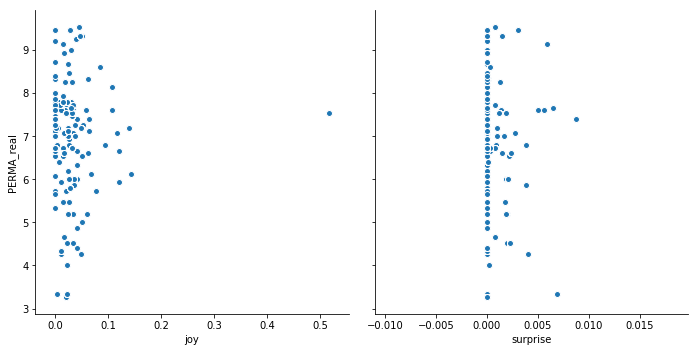

In [150]:
sns.pairplot(pair_df,x_vars=['joy','surprise'],y_vars=y_vars,size=5)

In [ ]:
corr_matrix = .corr()

In [ ]:
corr_matrix.head()